# IMPORTS

In [75]:
import os
import time
import warnings
from IPython.display import clear_output

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from nltk.corpus import stopwords

from scipy.sparse import csr_array

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# CONFIGURATION

In [2]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# SAMPLINg
SAMPLING_SIZE = 1000

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()

# FONCTIONS

In [99]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def get_stop_words(reviews: pd.DataFrame, min_df = 1, max_df = 0, verbose = 0):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if token not in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1

    words = dict(sorted(words.items(), key=lambda item: item[1]))

    # Remove english stop word
    english_sw = stopwords.words('english')
    words_wo_sw = {token:words[token] for counter, token in enumerate(words) if token not in english_sw}

    # Drop most frequent
    most_frequent = [[token, words_wo_sw[token]] for counter,token in enumerate(words_wo_sw) if counter > len(words_wo_sw) - max_df - 1]
    if verbose > 1 : 
        print(f'Les {max_df} mots les plus fréquents:')
        print(tabulate(most_frequent[::-1], headers=['mot', 'Nombre d\'apparitions']))
        print('')

    # Drop frequency under
    frequency_under = [token for token, count in words_wo_sw.items() if count < min_df]
    if verbose > 1:
        print(f'{len(frequency_under)} mots apparaissent moins de {min_df} fois:')
        np_treshold = np.get_printoptions()['threshold']
        np.set_printoptions(threshold=20)
        print(np.array(frequency_under))
        np.set_printoptions(threshold=np_treshold)
        print('')

    sw = list(set(stopwords.words('english') + list(np.array(most_frequent).T[0]) + frequency_under))

    return sw, len(words)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

def get_vocabulary_matrix(reviews: pd.DataFrame):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for review in list(reviews['tokens']):
        for token in review:
            index = vocabulary.setdefault(token, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr = csr_array((data, indices, indptr), dtype=int).toarray()

    return csr

def lda(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    if verbose > 1: print('  - Vectorisation (tf-idf)')
    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    # Topics from LDA
    if verbose > 1: print('  - Modélisation LDA')
    model_lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=0,
            n_jobs=-1)
    model_lda.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model_lda.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics

# PREVISUALISATION DES DATASETS

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
755,zQ3tnBABoypncWu5oW2bKA,Huddles Frozen Yogurt,"110 W Main St, Ste 115",Carmel,IN,46032,39.978629,-86.128785,4.5,19,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Ice Cream & Frozen Yogurt, Food","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
798,Gki1ureeRKqlIkQ-AELDVg,Brugada,204 Commerce St,Nashville,TN,37201,36.163323,-86.776592,3.5,49,1,"{'NoiseLevel': ''average'', 'Caters': 'False',...","Restaurants, Nightlife, Dance Clubs, Falafel, ...","{'Monday': '17:0-2:30', 'Tuesday': '17:0-2:30'..."
909,Iuir7lUtx-LMhYtStwyf3Q,Another Broken Egg Cafe,"5025 E 82nd St, Ste 2500",Indianapolis,IN,46250,39.904151,-86.083809,4.0,26,1,"{'WheelchairAccessible': 'True', 'RestaurantsG...","American (Traditional), Restaurants, Breakfast...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ..."
777,wcpL6sD6jKsBO0tbdK2KEA,McDonald's,8907 E 116th St,Fishers,IN,46038,39.957582,-86.010663,2.0,34,1,"{'Alcohol': ''none'', 'RestaurantsReservations...","Restaurants, Coffee & Tea, Fast Food, Burgers,...","{'Monday': '5:0-0:0', 'Tuesday': '5:0-0:0', 'W..."
836,MVmJuns9ZD9QLGltc0Am8g,Triple R's Smokehouse,1414 W Main St,Mascoutah,IL,62258,38.493585,-89.820789,4.5,8,0,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Restaurants, Barbeque","{'Tuesday': '11:0-20:0', 'Wednesday': '11:0-20..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
423,-Bhoyo7LL97tgt9Hze0Saw,"2012-08-18 12:59:32, 2012-08-26 12:40:40, 2012..."
617,-Hg66dRkB068suCcwLxsYQ,"2015-04-04 17:33:09, 2018-03-11 17:57:00, 2018..."
709,-Kisb17pdztyIHZvGPSvbg,"2010-03-27 20:23:07, 2010-09-24 19:47:58, 2010..."
192,-4UMCvj8E1PYseKhNfdoug,2015-11-17 16:52:16
196,-4VqKKSV3cT9Mjs7HYxMOw,"2012-01-01 01:49:12, 2012-09-15 20:55:16, 2013..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
934,3JPkxBo5HZBqsEfkNALKhg,d_fc9n5mQFFdoUxrOSeMAQ,Wd9JBLjCCh5yTF0vPAxCAA,4,1,0,0,We found ourselves in South Tucson needing a g...,2012-02-01 21:42:46
153,-pBDXBop_8v1dKk-BBpyzQ,YW0CUT7vA7pqn2f6aL8rlg,vPlhhf6CcB5dzQv1sEwlvg,5,1,1,1,Planet fitness gets four stars just because it...,2014-09-25 11:44:08
202,JH6ICJPlTj0ASN2THlnP0A,_bWkbDmhgFURzQ6VsULgtQ,LnQRfj3pPz0369stRnwUWw,4,0,0,0,"1st time eating here. Very clean, nice folks a...",2016-08-12 21:55:51
642,CQ-dwNoxvYTOD5-HNJEjeA,Sg6nAp9Ru1a2axJACwjNsA,YeMouev-sLfAxykmcANNoQ,1,0,0,0,"Horrible experience, pizza was soggy and cold ...",2015-04-29 03:17:30
170,UanAtEVU2kZ5hYu9h41MLg,mpqQv4T4iDJRVr4a2tZdHw,iVegX9epKU8R0eRAEwQ6Yg,5,1,0,0,Cindy is the best! Great food and service. Foo...,2018-09-22 01:41:14


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
251,CYkNedtMlfC8HQ3VBwQCOg,wL_5DIYA06jXzqV3FMhfBg,Patio + limonata: perfect for a beautiful day ...,2011-04-10 20:38:46,0
330,60RKNAZwY5EUooJf624aKw,QJfM8uRNy6KHhj6kIatzmg,True fresh squeezed OJ (and other juices) are ...,2015-05-30 15:44:02,0
853,h2-pMGh4DpIEO-MsQY4RqQ,w_4xUt-1AyY2ZwKtnjW0Xg,It's pretty good I think they could work on cu...,2013-05-19 03:20:29,0
717,zAMpV0uFt9XpqRDFNLWPrQ,IcG1KU2mZHLn7OFmUTwNXw,Try the Gruyere salad! Their Wednesday Fried C...,2015-05-28 17:31:43,0
109,jlN9luFsNZfZkxnM7cdLKQ,cv-SmPhbpwQCtlI2Q7KJIQ,Very good shanghai soup dumplings,2013-09-06 23:58:56,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
589,JprmPc4cZ_TrydXRhWo2gg,Daisy,6,2010-09-13 12:23:52,2,3,2,,"nSvQMiDu0DWUycOUy0qa2w, mbU9AVn-R9Zi6v39D475-Q...",2,...,0,0,0,0,0,0,0,0,0,0
310,Fio9RpyMAejPEsZhDFdb5w,T,249,2009-07-14 17:17:57,291,91,154,"2010,2011,2012,2013","fwdvIW8G_Hhgku0ANvtppg, YttDgOC9AlM4HcAlDsbB2A...",20,...,1,0,2,0,20,27,39,39,9,5
484,itm7J1IWFo3YGBwcZUin9g,Quynh,21,2011-05-03 05:26:11,36,2,11,,"e5CBcg4OQ3kEwx5TjGTLJg, vw2Ka2EZ2_8cFI0LgQGYXA...",6,...,0,0,0,0,2,1,0,0,1,0
261,GcWXTgLffuZ5BsuZGcl02Q,Anna,149,2007-05-31 13:40:23,255,62,87,"2009,2010","dkDqseg4l4R2yJhOWj2xPw, kUCae_jdXJXHf5vA6h1-Xg...",12,...,2,1,4,3,8,5,12,12,6,4
805,q-0qnT8ommeAyJb2Tv7AJA,Andrew,21,2011-04-17 14:23:43,33,20,7,,"VVumRvFJ9vcOshTaUUQtTQ, 27DgtDXgv7c0aq6y0__Mww...",3,...,1,0,0,0,0,2,0,0,0,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

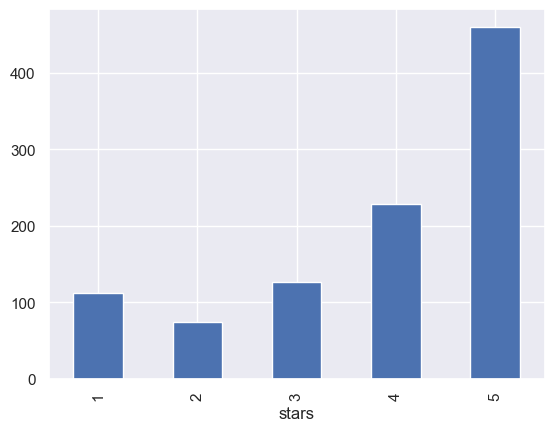

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

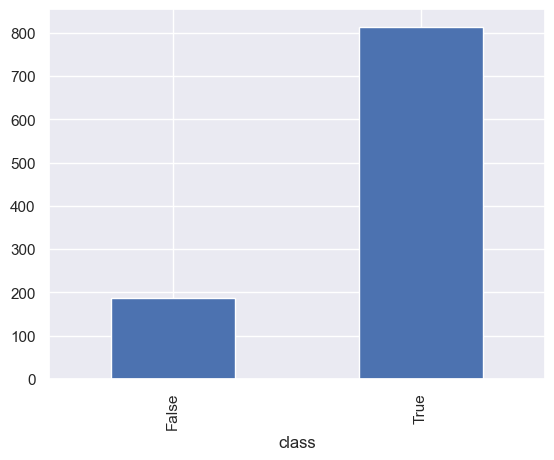

In [9]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

121442    [Home Services, Siding, Gutter Services, Roofing]
35022     [Yoga, Beauty & Spas, Massage, Fitness & Instr...
110475                    [Ice Cream & Frozen Yogurt, Food]
14369     [Shopping, Discount Store, Food, Grocery, Fash...
123518    [Men's Clothing, Bridal, Fashion, Formal Wear,...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurant Supplies', 'Restaurants']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Tours',
 'Do-It-Yourself Food',
 'Food Banks',
 'Ethnic Food',
 'Live/Raw Food',
 'Food',
 'Comfort Food',
 'Food Trucks',
 'Specialty Food',
 'Seafood',
 'Fast Food',
 'Soul Food',
 'Food Court',
 'Imported Food',
 'Food Delivery Services',
 'Food Stands',
 'Seafood Markets']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')
restaurants_ids[0:10]

52268 business sont des Restaurants


['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [54]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

## Visulisation synthetique des reviews par note

In [59]:
def review_word_cloud(reviews, min_df = 4, max_df = 100, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    if verbose > 0: 
        print(f'\nSuppression par fréquence\n=================')
        print(f'  - {max_df} mots les plus fréquents')
        print(f'  - apparaisant moins de {min_df} fois\n')

    stop_words, nb_words_original = get_stop_words(reviews, min_df, max_df, verbose)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    cloud_sample_size = min(reviews.shape[0], 1000)
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
    sample_text = ' '.join(reviews.sample(cloud_sample_size, random_state=0)['tokens'].str.join(' ').values)
    word_cloud(text=sample_text)
    print('')

Note = 5


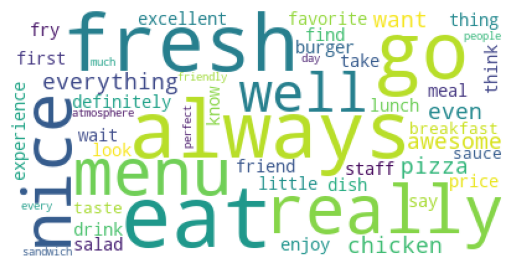


Note = 4


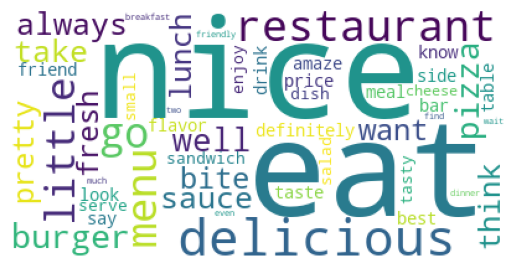


Note = 3


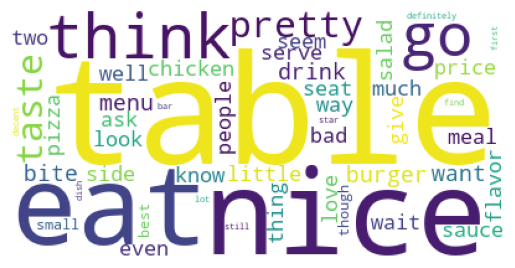


Note = 2


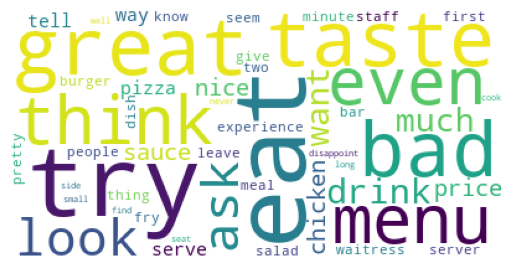


Note = 1


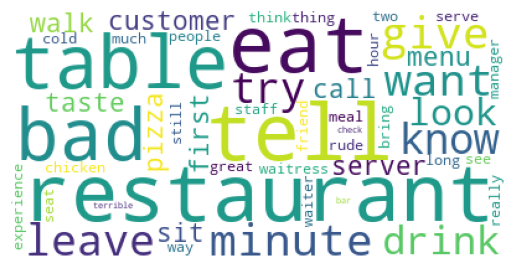

In [61]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    review_word_cloud(reviews=get_reviews(stars=stars),
                      min_df=2,
                      max_df=20)

## TF-IDF + PCA/TSNE

In [42]:
def tf_idf(reviews, min_df = 4, max_df = 100, tsne_target = None, pca_target = None, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words="english", sublinear_tf=True,ngram_range=(1,2))
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        for index in df.sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    if tsne_target:
        X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=35).fit_transform(values)
        tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y'])
        tsne_df['hue'] = reviews[tsne_target]
        sns.scatterplot(data=tsne_df, x='x', y='y', hue='hue')
        plt.show()

    if pca_target:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(values.toarray())
        pca_df = pd.DataFrame(X_pca, columns=['x', 'y'])
        pca_df[pca_target] = reviews[pca_target]
        ax = sns.scatterplot(data=pca_df, x='x', y='y', hue=pca_target, alpha=0.6)

        # Fx labels
        f1 = ', '.join(vectorizer.get_feature_names_out()[np.flip(np.argsort(pca.components_[0])[-5:])]) + '...'
        f2 = ', '.join(vectorizer.get_feature_names_out()[np.flip(np.argsort(pca.components_[1])[-5:])]) + '...' 

        ax.set(xlabel=f'F1: {f1}',
               ylabel=f'F2: {f2}',
               title='PCA')
        
        plt.show()

    return values, vectorizer, pca

Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


,100,1st,2nd,able,absolute,absolutely,accept,accommodate,acknowledge,act,...,yell,yelp,yes,yesterday,york,young,yuck,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.262554,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.212173,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| Great food, great drinks, terribly (unapologetically so) service. It's not dick's last resort, it's  | ask water: 0.3047        |
| not your shtick to be shitty... We had to ask for water four times and when we got it, it was luke   | busy: 0.1874             |
| warm.......annnnnd it wasn't busy.  like the vibe would consider coming back for drinks but would    | come drink: 0.3005       |
| have to mentally prepare I was walking into a shit show.                                             | consider: 0.2426         |
|                                                                           

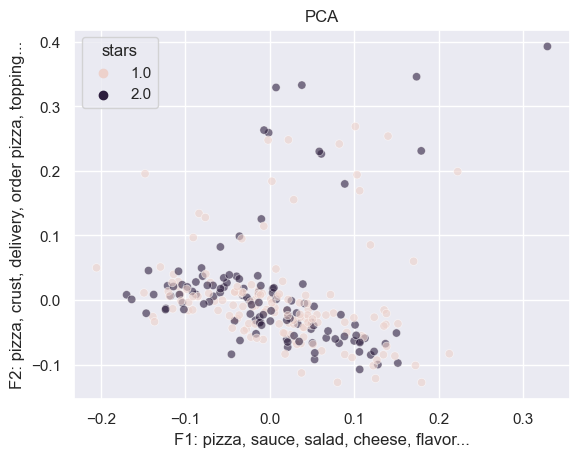

In [49]:
reviews = get_reviews(max_stars=2)
values, vectorizer, pca = tf_idf(reviews=reviews, min_df=10, max_df=0.1, pca_target='stars', verbose=1)

## FINDING TOPICS

In [101]:
def find_topics(reviews, type  ='lda', min_df = 4, max_df = 100, n_topics = 10, n_topic_top_words=10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)

    if type == 'lda':
        topics = lda(reviews, min_df = 4, max_df = 100, n_topics=n_topics, n_top_words=n_topic_top_words, ngram_range=ngram_range, verbose=verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

In [103]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     min_df=2,
                     max_df=20,
                     n_topics=5, 
                     n_topic_top_words=5,
                     ngram_range=(2,3),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -----------------------------------------------------------------
         0  not recommend, taco bell, wait minute, look like, would not
         1  open door, chocolate chip, much like, walk few, order special
         2  time money, waste time, waste time money, feel like, non existent
         3  food price, not even, service rude, customer service, day old
         4  not good, food not, very disappoint, go back, very good


In [105]:
topics_grid = []
start = time.time()
LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

min_df_range = [2, 10]
max_df_range = [100, 0.1, 0.3]
n_topics_range = [5]
n_grams_range = [(1,2),(2,3),(3,3)]

total_loops = len(min_df_range)*len(max_df_range) * len(n_topics_range) * len(n_grams_range)
current_loop = 1
for min_df in min_df_range:
    for max_df in max_df_range:
        for n_topics in n_topics_range:
            for ngram_range in n_grams_range:
                print(f'Recherche {current_loop}/{total_loops}')
                print(f'Temps écoulé {time_from(start)}')
                print(f'Parametres:')
                hyper_params = [['Fréquence minimal d\'un mot', min_df], ['Top des mots les plus fréquent supprimés', max_df], ['N Grams', ngram_range], ['Nombre de topics', n_topics]]
                print(tabulate(hyper_params,))
                topics = find_topics(reviews=get_reviews(max_stars=2),
                                     min_df=min_df,
                                     max_df=max_df,
                                     n_topics=n_topics, 
                                     n_topic_top_words=5,
                                     ngram_range=ngram_range,
                                     verbose=0)
                current_loop = current_loop + 1
                clear_output()
                topics_grid.append({'params': 'min_df\nmax_df\nn_grams' ,
                                    'value': str(min_df) + '\n' + str(max_df) + '\n' + str(ngram_range),
                                    'topics': '\n'.join([str(topic[0]) + ' : ' + topic[1] for topic in topics])
                                   })

print(f'{total_loops} boucles éxécutées en {time_from(start)}\n\n')
print(tabulate(topics_grid,  headers="keys", tablefmt="grid"))
        

18 boucles éxécutées en 1mn 43s


+----------+---------+----------------------------------------------------------------------------------------------------+
| params   | value   | topics                                                                                             |
+==========+=========+====================================================================================================+
| min_df   | 2       | 0 : beer, roll, breakfast, taco, steak                                                             |
| max_df   | 100     | 1 : wifi, drink get, get work, sunday, turn                                                        |
| n_grams  | (1, 2)  | 2 : hard rock, chicken tender, bad chicken, rock, tender                                           |
|          |         | 3 : cold food, freeze, send, new york, include                                                     |
|          |         | 4 : area not, not fill, unnecessary, ability, domino                       